In [ ]:
import torch
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from time import time
%load_ext tensorboard

<!-- # Steps
1. Visualize the dataset
2. Understand the task
3. Transform the input and target data to perform the task
4. Design a model according to the data's specs
5. Find a loss function that suits the task
6. Choose the optimizer algorithm
7. Design the technique used to avoid overfitting
8. Organize the dataset into subsets according the technique mentioned above
9. Find a/the metric(s) to evaluate your model's performance
10. Build the training+val loop
11. Build the test/evaluate loop to observe the results
12. Start training with modest hyper-param values
13. Tune one hyper param at a time to observe its effect on training -->

1. Visualiser le dataset
2. Comprendre le problème
3. Transformer les données d'entrée et les cibles
4. Concevoir une architecture de réseau de neurones en fonction des données et du problème.
5. Choisir une fonction de coûts qui répond au problème
6. Choisir l'algorithme d'optimisation
7. Choisir la technique pour éviter le sur-entraînement du modèle
8. Diviser le dataset en sous-groupes en fonction de la technique choisie à l'étape 7
9. Choisir les indicateurs (metric) pour évaluer la performance du modèle.
10. Implémenter la boucle d'entraînement et de validation
11. Implémenter la boucle de test pour observer les performances du modèle final.
12. Débuter l'entraînement avec des valeurs conservatrices pour les hyper-paramètres
13. Ajuster un seul paramètre à la fois pour observer l'influence de la modification sur l'entraînement et les performances.

#Step 1 - Visualiser le dataset

In [ ]:
# create training dataset instance
train_dataset = CIFAR10(root='./data', 
                        train=True,
                        transform=None,
                        target_transform=None,
                        download=True)

# create the dataset instance for final model testing
test_dataset = CIFAR10(root='./data',
                       train=False,
                       transform=None,
                       target_transform=None,
                       download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# peek at the first sample
sample = train_dataset[1]
print(sample)

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FECE967F438>, 9)


image original size (height, width) = (32, 32)

Image's class label is truck
Training dataset has 50000 samples
Test dataset has 10000 samples
the sample image has 3 color channels


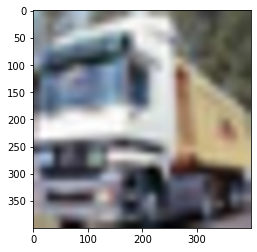

In [ ]:
# we can see the sample is actually a tuple ( PIL Image instance, Int)
# the first element is the input image as a Pillow image
# the second element is the zero-indexed target class label of that image.
sample_image, sample_class_label = sample

# CIFAR10 has 10 possible classes

classes = ('plane',  # id 0
           'car',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')  # id 9

# print the image original size
print(f"image original size (height, width) = {sample_image.size}\n")

# Show the resized image and its label
print(f"Image's class label is {classes[sample_class_label]}")
plt.imshow(np.array(sample_image.resize(size=(400, 400))))

# How many samples do we have in the training dataset ?
print(f"Training dataset has {len(train_dataset)} samples")
# And in the test set ?
print(f"Test dataset has {len(test_dataset)} samples")

# what about the color channels ?
print(f"the sample image has {np.array(sample_image).shape[2]} color channels")

#Step 2
##Comprendre le problème

We know we have images as input data and class labels as targets. Thus, we want to create a mapping between the images and their class label. 
However, there is no parametric function that can take an image it has never seen before and associate the right class label every time.

Since we cannot take a mathematical formula to compute the class label, we must find an approximation function that will represent the transformation between the input image and the output class label.
Fortunetely, we will see how we can achieve this by using artificial neural networks to predict the class labels.


<a id="step_3"></a>

#Step 3
##Transformer les données d'entrée et les cibles

In [ ]:
# Remember our sample_image was a PIL Image right ?
# We need to transform it to a tensor and normalize its values from the
# 0-255 range to the 0-1 range. This transformation will improve model stability.
input_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Recreate our datasets but this time with the transform
train_dataset = CIFAR10(root='./data', 
                        train=True,
                        transform=input_transform,
                        target_transform=None,
                        download=True)

test_dataset = CIFAR10(root='./data',
                       train=False,
                       transform=input_transform,
                       target_transform=None,
                       download=True)

Files already downloaded and verified
Files already downloaded and verified


### Create data loaders 
Loaders will sample mini-batches of data that the model will process in parallel on the GPU. In addition, the loss will be computed as the average over all the samples in the batch, hence a bigger mini-batch will result in a less noisy computed gradient

In [ ]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)

#Step 4
##Concevoir une architecture de réseau de neurones en fonction du problème et des données.

In [ ]:
# class CNN(nn.Module):
#     def __init__(self,
#                  hidden_activation_function='relu',
#                  head_activation_function='softmax'):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=8,
#                                kernel_size=5,
#                                stride=1)

#         self.pool = nn.MaxPool2d(kernel_size=2)
#         # after conv1 + pool
#         # 14x14x8

#         self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,
#                                kernel_size=5,
#                                stride=1)
#         # after conv2 + pool
#         # 5x5x16
                               
#         self.fc1 = nn.Linear(in_features=5*5*16, out_features=128)
#         self.fc2 = nn.Linear(in_features=128, out_features=10)

#         # hidden layers activation function
#         if hidden_activation_function == 'relu':
#             self.hidden_act_func = F.relu
#         elif hidden_activation_function == 'sigmoid':
#             self.hidden_act_func = F.sigmoid
#         elif hidden_activation_function == 'tanh':
#             self.hidden_act_func = F.tanh
#         else:
#             raise Exception('unknown activation function')

#         # output activation function
#         if head_activation_function == 'softmax':
#             self.head_activation_func = F.softmax
#         elif head_activation_function == 'hardsigmoid':
#             self.head_activation_func = F.hardsigmoid
    
#     def forward(self, x):
#         x = self.pool(self.hidden_act_func(self.conv1(x)))
#         x = self.pool(self.hidden_act_func(self.conv2(x)))
#         x = self.hidden_act_func(self.fc1(x.view(-1, 5*5*16)))

#         # head
#         x = self.fc2(x)
#         out = self.head_activation_func(x)

#         return out

class CNN(nn.Module):
    def __init__(self,
                 hidden_activation_function='relu',
                 head_activation_function='softmax'):
        super(CNN, self).__init__()
        self.norm_layer = nn.BatchNorm2d
        self.relu = nn.ReLU(inplace=True)



        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=0, bias=False)
        self.bn1 = self.norm_layer(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2,
                                  stride=2)
        # after conv1 + pool1
        # 16x14x14

        self.conv2_1 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2_1 = self.norm_layer(16)
        # 16x14x14
        self.conv2_2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2_2 = self.norm_layer(16)
        # 16x14x14

        self.conv3_1 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn3_1 = self.norm_layer(16)
        # 16x14x14
        self.conv3_2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn3_2 = self.norm_layer(16)
        # 16x14x14

        self.conv4_1 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn4_1 = self.norm_layer(16)
        self.conv4_2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn4_2 = self.norm_layer(16)

        # downsample
        self.conv5_1 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        # 32x7x7
        self.bn5_1 = self.norm_layer(32)
        self.conv5_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn5_2 = self.norm_layer(32)

        self.conv6_1 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn6_1 = self.norm_layer(32)
        self.conv6_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn6_2 = self.norm_layer(32)

        self.downsample_skip_conn_1 = nn.Sequential(
            nn.Conv2d(16, 32, 1, stride=2, bias=False),
            self.norm_layer(num_features=32)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(32, 10)



        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        identity_1 = x

        x = self.bn2_1(self.conv2_1(x))
        x = self.relu(x)
        x = self.bn2_2(self.conv2_2(x))
        x += identity_1
        x = self.relu(x)
        identity_2 = x

        x = self.bn3_1(self.conv3_1(x))
        x = self.relu(x)
        x = self.bn3_2(self.conv3_2(x))
        x += identity_2
        x = self.relu(x)
        identity_3 = x

        x = self.bn4_1(self.conv4_1(x))
        x = self.relu(x)
        x = self.bn4_2(self.conv4_2(x))
        x += identity_3
        x = self.relu(x)
        identity_4 = x

        x = self.bn5_1(self.conv5_1(x))
        x = self.relu(x)
        x = self.bn5_2(self.conv5_2(x))
        x += self.downsample_skip_conn_1(identity_4)
        x = self.relu(x)
        identity_5 = x

        x = self.bn6_1(self.conv6_1(x))
        x = self.relu(x)
        x = self.bn6_2(self.conv6_2(x))
        x += identity_5
        x = self.relu(x)
        identity_6 = x

        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x




### Initialize the model

```
classifier = CNN()
```

#Step 5
##Choisir une fonction de coûts qui répond au problème

```python
criterion = nn.CrossEntropyLoss()
```

#Step 6
##Choisir l'algorithme d'optimisation

```
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
```


#Step 7
##Choisir la technique pour éviter le sur-entraînement du modèle


#Step 8
##Diviser le dataset en sous-groupes en fonction de la technique choisie à l'étape 7

In [ ]:
torch.manual_seed(1)
def get_data_loaders(training_batch_size=32):
    input_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                         std=(0.5, 0.5, 0.5))
    ])
    
    # Recreate our datasets but this time with the transform
    train_dataset = CIFAR10(root='./data', 
                            train=True,
                            transform=input_transform,
                            target_transform=None,
                            download=True)

    val_dataset = CIFAR10(root='./data', 
                          train=True,
                          transform=input_transform,
                          target_transform=None,
                          download=True)
    
    test_dataset = CIFAR10(root='./data',
                           train=False,
                           transform=input_transform,
                           target_transform=None,
                           download=True)

    indices = torch.randperm(len(train_dataset)).tolist()

    # split the train_dataset into two subsets
    # one for training and the other for validation after every training epoch
    split_point = 45000  # keep 10% of the training_set (5000/50000) for validation
    
    train_dataset = torch.utils.data.Subset(train_dataset,
                                            indices[:split_point])
    print(f"train_dataset has {len(train_dataset)} samples")

    validation_dataset = torch.utils.data.Subset(val_dataset,
                                                 indices[split_point:])
    print(f"validation_dataset has {len(validation_dataset)} samples")
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=training_batch_size,
                                               shuffle=True,
                                               num_workers=4)
    
    validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                    batch_size=100,
                                                    shuffle=False,
                                                    num_workers=2)

    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=1,
                                              shuffle=False,
                                              num_workers=4)

    return train_loader, validation_loader, test_loader



#Step 9

##Choisir les indicateurs (metric) pour évaluer la performance du modèle.

In [ ]:
from sklearn.metrics import accuracy_score

def get_score(preds, targets):
    """
    """
    # torch.max() returns a named tuple
    # (values, indices)

    y_pred = torch.max(preds, dim=1)[1].numpy()  # we want the indices (class labels)

    score = accuracy_score(y_true=targets.numpy(),
                           y_pred=y_pred,
                           normalize=True)  # the fraction of valid predictions
    # TODO check if normalize=False is better
    # because the average score is computed over all the validation batches
    return score

#Step 10

##Implémenter la boucle d'entraînement et de validation

In [ ]:
def train_one_epoch(classifier,
                    optimizer,
                    criterion,
                    train_set,
                    current_step,
                    writer):
    """
    """
    average_loss = 0
    total_loss = 0
    n = len(train_set)
    # iterate through the samples of the training set
    for training_step, (img_batch, target_batch) in enumerate(train_set):
        optimizer.zero_grad()

        predictions = classifier(img_batch.to(device))

        # compute the error between the predictions and the ground truths
        loss = criterion(predictions, target_batch.to(device))

        loss.backward()
        optimizer.step()
        
        total_loss += loss.detach().cpu().numpy()


    average_loss = total_loss / n
    writer.add_scalar('Loss/train',
                      average_loss,
                      current_step+training_step)
    return current_step+training_step
    


In [ ]:
@torch.no_grad()
def validate(classifier,
             criterion,
             val_set,
             metric_func,
             epoch,
             writer):
    """
    """
    total_validation_loss = 0
    total_score = 0
    n = len(val_set)
    for img_batch, target_batch in val_set:
        predictions = classifier(img_batch.to(device))
        val_loss = criterion(predictions, target_batch.to(device))
        score = metric_func(predictions.cpu(), target_batch.cpu())
        total_validation_loss += val_loss.cpu().numpy()
        total_score += score

    average_validation_loss = total_validation_loss / n
    average_score = total_score / n

    writer.add_scalar('Loss/validation',
                      average_validation_loss,
                      epoch)
    writer.add_scalar('Accuracy/validation',
                      average_score,
                      epoch)

#Step 11

##Implémenter la boucle de test pour observer les performances du modèle final.

In [ ]:
def test(classifier,
         test_set,
         metric_func,
         writer):

    classifier.eval()

    total_score = 0
    n = len(test_set)

    for img_batch, target_batch in test_set:
        predictions = classifier(img_batch.to(device))
        score = metric_func(predictions.cpu(), target_batch.cpu())

        total_score += score
    
    average_score = total_score / n

    writer.add_scalar('Accuracy/test',
                      average_score)
                      
    return average_score

#Step 12

##Débuter l'entraînement avec des valeurs conservatrices pour les hyper-paramètres

In [ ]:
%tensorboard --logdir runs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 33530.

In [ ]:
EXPERIMENT_NUMBER = 0

BATCH_SIZE = 32
# Get the data loaders
train_set, val_set, test_set = get_data_loaders(BATCH_SIZE)

0.1%

14.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

35.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

57.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

79.2%IOPub

In [ ]:
# define on which device the tensor operations will be computed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("gpu is available" if torch.cuda.is_available() else "running on cpu")

# change this number to create a new entry in the logs
# this number will increment at each new experiment and this will create a new
# entry in the logs to observe the effects of a change in hyper parameters
EXPERIMENT_NUMBER += 1

writer = SummaryWriter(log_dir=f"runs/experiment_{EXPERIMENT_NUMBER}",
                       flush_secs=10)


# ------------------------------------------------------------
# HYPER PARAMETERS
# ------------------------------------------------------------
NUM_EPOCHS = 30
LEARNING_RATE = 0.1
MOMENTUM = 0.0
NUM_EPOCHS_BETWEEN_LR_REDUCTION = 8
LR_REDUCTION_RATIO = 0.1
HIDDEN_LAYERS_ACTIVATION_FUNCTION = 'relu'
HEAD_ACTIVATION_FUNCTION = 'softmax'
# ------------------------------------------------------------
hparams = {
    'lr': LEARNING_RATE,
    'Momentum': MOMENTUM,
    'batch_size': BATCH_SIZE,
    'num_epochs_between_lr_reduction': NUM_EPOCHS_BETWEEN_LR_REDUCTION,
    'lr_reduction_ratio': LR_REDUCTION_RATIO,
}

# write hyper params to summary
writer.add_hparams(hparam_dict=hparams, metric_dict={})

print("initialize model")
# instanciate the model
classifier = CNN(HIDDEN_LAYERS_ACTIVATION_FUNCTION,
                 HEAD_ACTIVATION_FUNCTION)

# send classifier to device
classifier.to(device)

# set classifier in training mode
classifier.train()

# instanciate the loss function and the model optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(),
                            lr=LEARNING_RATE,
                            momentum=MOMENTUM)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=NUM_EPOCHS_BETWEEN_LR_REDUCTION,
                                               gamma=LR_REDUCTION_RATIO)

print("start training")
current_step = 0

for epoch in range(NUM_EPOCHS):
    
    print(f"EPOCH #{epoch+1}")

    current_step = train_one_epoch(classifier,
                                   optimizer,
                                   criterion,
                                   train_set,
                                   current_step,
                                   writer)
    print(f"validation for epoch {epoch+1}")
    # validate the model on val_set
    validate(classifier,
             criterion,
             val_set,
             get_score,
             epoch,
             writer)
    
    lr_scheduler.step()

print("Evaluating model on test set")
average_accuracy = test(classifier,
                        test_set,
                        get_score,
                        writer)
print(f"Test average accuracy: {average_accuracy*100} %")

gpu is available
initialize model
start training
EPOCH #1
validation for epoch 1
EPOCH #2
validation for epoch 2
EPOCH #3
validation for epoch 3
EPOCH #4
validation for epoch 4
EPOCH #5
validation for epoch 5
EPOCH #6
validation for epoch 6
EPOCH #7
validation for epoch 7
EPOCH #8
validation for epoch 8
EPOCH #9
validation for epoch 9
EPOCH #10
validation for epoch 10
EPOCH #11
validation for epoch 11
EPOCH #12
validation for epoch 12
EPOCH #13
validation for epoch 13
EPOCH #14
validation for epoch 14
EPOCH #15
validation for epoch 15
EPOCH #16
validation for epoch 16
EPOCH #17
validation for epoch 17
EPOCH #18
validation for epoch 18
EPOCH #19
validation for epoch 19
EPOCH #20
validation for epoch 20
EPOCH #21
validation for epoch 21
EPOCH #22
validation for epoch 22
EPOCH #23
validation for epoch 23
EPOCH #24
validation for epoch 24
EPOCH #25
validation for epoch 25
EPOCH #26
validation for epoch 26
EPOCH #27
validation for epoch 27
EPOCH #28
validation for epoch 28
EPOCH #29
validat

#Step 13

##Ajuster un seul paramètre à la fois pour observer l'influence de la modification sur l'entraînement et les performances.

#TODO
2. Add the possibility to save the model at the end of training
6. Add Insights for parameter tuning